In [1]:
#读入T5-small进circallm，然后以后用这个circallm进行预训练
from argparse import Namespace
from models.circaLLM import CIRCALLM
config_dict = {
    "task_name": "classification", 
    "model_name": "CIRCALLM", 
    "transformer_type": "encoder_only", 
    "freeze_embedder":False,
    "freeze_encoder":False,
    "freeze_head":False,
    "learning_rate":1e-6,
    "num_epochs":20,
    "n_channels": 1,
    "num_class": 2,
    'reduction': 'mean',
    "d_model": None, 
    "seq_len": 72,
    'enable_gradient_checkpointing': False,
    "enable_FAN":True,
    "enable_FAN_gate":True,
    "patch_len": 6, 
    "patch_stride_len": 6, 
    "device": "cpu", 
    "transformer_backbone": "google/flan-t5-small", 
    "model_kwargs": {},
    "t5_config": {
        "architectures": ["T5ForConditionalGeneration"],
        "d_ff": 1024,
        "d_kv": 64,
        "d_model": 512,
        "decoder_start_token_id": 0,
        "dropout_rate": 0.1,
        "eos_token_id": 1,
        "feed_forward_proj": "gated-gelu",
        "initializer_factor": 1.0,
        "is_encoder_decoder": True,
        "layer_norm_epsilon": 1e-06,
        "model_type": "t5",
        "n_positions": 72,
        "num_decoder_layers": 6,
        "num_heads": 8,
        "num_layers": 6,
        "output_past": True,
        "pad_token_id": 0,
        "relative_attention_max_distance": 128,
        "relative_attention_num_buckets": 32,
        "tie_word_embeddings": False,
        "use_cache": True,
        "vocab_size": 32128
    }
}

# 将字典转换为 Namespace 对象
config = Namespace(**config_dict)

model =CIRCALLM(config)
print(model)

d:\Software\Anaconda3\envs\circallm\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CIRCALLM(
  (normalizer): RevIN()
  (data_embedding): CircaDataEmbedding(
    (value_embedding): CircaTokenEmbedding(
      (tokenConv): Conv1d(1, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): CircaTemporalEmbedding(
      (minute_embed): FixedEmbedding(
        (emb): Embedding(60, 512)
      )
      (hour_embed): FixedEmbedding(
        (emb): Embedding(72, 512)
      )
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=

In [3]:
import torch

state_dict=torch.load("pretrained/RealDST_T1/best_model.pth")
model.load_state_dict(state_dict["model_state_dict"])
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = torch.nn.BCEWithLogitsLoss()

C:\Users\cen\AppData\Local\Temp\ipykernel_29032\1197025114.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict=torch.load("pretrained/RealDST_T1/best_model.pth")


In [4]:
from tqdm import tqdm 
import numpy as np
def train_epoch(model,device,train_dataloader,optimizer,criterion,scheduler):
    '''
    Train encoder and classification head (with accelerate enabled)
    '''
    model.to(device)
    model.train()

    all_targets,all_preds,all_scores = [],[],[]
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_data, input_mask,x_marks, targets in tqdm(train_dataloader, total=len(train_dataloader)):
        optimizer.zero_grad()
        batch_data = batch_data.to(device).float()
        input_mask, x_marks=input_mask.long().to(device), x_marks.to(device)
        total += targets.size(0)
        targets=targets.unsqueeze(1).float().to(device)
        all_targets.extend(targets.detach().int().cpu().numpy())
        

        with torch.autocast(device_type='cuda', dtype=torch.bfloat16 if torch.cuda.is_available() and torch.cuda.get_device_capability()[0] >= 8 else torch.float32):
            output = model(x_enc=batch_data, input_mask=input_mask,x_mark=x_marks,reduction=config.reduction)
            logits=output.logits
            loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()
        #loss计算
        running_loss += loss.item()

        #预测标签获取
        # scores=torch.softmax(logits,dim=1)
        # _, predicted = torch.max(scores, 1)
        scores=torch.sigmoid(logits)
        predicted = (scores > 0.5).int()
        all_preds.extend(predicted.detach().cpu().numpy())

        #统计预测正确的标签的个数
        correct += (predicted == targets.int()).sum().item()

        #计算预测为正类的概率
        all_scores.extend(scores.detach().to(torch.float).cpu().numpy())



    all_targets = np.array(all_targets)
    all_preds = np.array(all_preds)
    all_scores = np.array(all_scores)
    
    avg_loss = running_loss / len(train_dataloader)
    accuracy = correct / total

    result={
        "loss":[avg_loss],
        "accuracy":[accuracy],
        "targets":all_targets.tolist(),
        "preds":all_preds.tolist(),
        "scores":all_scores.tolist(),
    }
    return result
def test_epoch(model,dataloader,device,criterion):
    return evaluate_epoch(model,dataloader,device,criterion)
    
def evaluate_epoch(model,dataloader,device,criterion):
    model.eval()
    model.to(device)

    all_targets, all_preds, all_scores = [],[],[]
    running_loss, correct, total = 0.0, 0,0
    with torch.no_grad():
        # i=0
        for batch_data, input_mask,x_marks, targets in tqdm(dataloader, total=len(dataloader)):
            # if i==5:
            #     break
            # i=i+1
            batch_data = batch_data.to(device).float()
            input_mask, x_marks=input_mask.long().to(device), x_marks.to(device)
            all_targets.extend(targets.detach().cpu().numpy())
            targets=targets.unsqueeze(1).float().to(device)
            total += targets.size(0)
            

            with torch.autocast(device_type='cuda', dtype=torch.bfloat16 if torch.cuda.is_available() and torch.cuda.get_device_capability()[0] >= 8 else torch.float32):
                output = model(x_enc=batch_data,input_mask=input_mask,x_mark=x_marks,reduction=config.reduction)
                logits=output.logits
                loss = criterion(logits, targets)

            running_loss += loss.item()

            #获取预测标签
            # scores=torch.softmax(logits,dim=1)
            # _, predicted = torch.max(scores, 1)
            scores=torch.sigmoid(logits)
            predicted = (scores > 0.5).int()
            all_preds.extend(predicted.detach().cpu().numpy())
            #统计预测正确的标签的个数
            correct += (predicted == targets.int()).sum().item()
            #计算预测为正类的概率
            all_scores.extend(scores.detach().to(torch.float).cpu().numpy())
    
    #计算关键指标precision,recall,F1-score,auc,AP,mAP
    all_targets = np.array(all_targets)
    all_preds = np.array(all_preds)
    all_scores = np.array(all_scores)

    #计算每个epoch平均loss和accuracy
    avg_loss = running_loss / len(dataloader)
    accuracy = correct / total
    result={
        "loss":[avg_loss],
        "accuracy":[accuracy],
        "targets":all_targets.tolist(),
        "preds":all_preds.tolist(),
        "scores":all_scores.tolist(),
    }
    return result

In [5]:
import os
def save_checkpoint(model,savePath="best_model.pth"):#"best_valModel.pth","current_model.pth"
    path = os.path.join("saved_nnets/RealDST-T1")
    #mkdir if not exist
    if not os.path.exists(path):
        os.makedirs(path)
    checkpoint = {
        'model_state_dict': model.state_dict()
    }
    torch.save(checkpoint, os.path.join(path, savePath))

In [6]:
import os
print(os.getcwd())
folder_path="../datasets/RealDST_T11/"
originFiles = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))]
files = [item for item in originFiles if '(12)' not in item]
files.sort()
# files[0:4], files[-4:] = files[-4:], files[0:4]
print(files)


file_paths = [folder_path + item +"/" for item in files] 
print(file_paths)

c:\Figshare\code
['GSE122152', 'GSE214530_Lung_IH', 'GSE214530_Lung_Norm', 'GSE25612', 'time_class_1,dup0', 'time_class_10,dup0', 'time_class_10,dup4', 'time_class_10,dup6', 'time_class_11,dup1', 'time_class_12,dup1', 'time_class_13,dup0', 'time_class_14,dup10', 'time_class_14,dup2', 'time_class_14,dup3', 'time_class_15,dup1', 'time_class_16,dup0', 'time_class_17,dup1', 'time_class_18,dup2', 'time_class_2,dup0', 'time_class_2,dup1', 'time_class_2,dup2', 'time_class_3,dup0', 'time_class_3,dup1', 'time_class_3,dup2', 'time_class_3,dup3', 'time_class_3,dup4', 'time_class_3,dup5', 'time_class_4,dup0', 'time_class_4,dup1', 'time_class_4,dup13', 'time_class_5,dup0', 'time_class_5,dup2', 'time_class_6,dup1', 'time_class_6,dup7', 'time_class_7,dup0', 'time_class_8,dup0', 'time_class_9,dup0', 'time_class_9,dup1', 'uneven_71620_1', 'uneven_71620_2']
['../datasets/RealDST_T11/GSE122152/', '../datasets/RealDST_T11/GSE214530_Lung_IH/', '../datasets/RealDST_T11/GSE214530_Lung_Norm/', '../datasets/Re

In [7]:
file_paths=file_paths[2:4]
file_paths

['../datasets/RealDST_T11/GSE214530_Lung_Norm/',
 '../datasets/RealDST_T11/GSE25612/']

In [8]:

from data_provider.classfication_datasets import MultipleDataset
from torch.utils.data import DataLoader
from utils.logging import CustomLogger
import torch



seed=77
# 创建 MultipleDataset 实例并加载数据
train_dataset = MultipleDataset(data_split="train", file_paths=file_paths,seq_len=72,seed=seed)
val_dataset = MultipleDataset(data_split="val", file_paths=file_paths,seq_len=72,seed=seed)
test_dataset = MultipleDataset(data_split="test", file_paths=file_paths,seq_len=72,seed=seed)


torch.manual_seed(seed)
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

TRAIN
    Loading 1th dataset ...
    Loading 2th dataset ...
VAL
    Loading 1th dataset ...
    Loading 2th dataset ...
TEST
    Loading 1th dataset ...
    Loading 2th dataset ...


In [9]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-4,total_steps=config.num_epochs*len(train_dataloader))

In [10]:
from utils.metrics import Metric
from datetime import datetime
current_time = datetime.now()
c_time = current_time.strftime("%y_%m_%d_%H_%M")

testSave={'loss':[],'accuracy':[],'targets':[],'preds':[],'scores':[]} 

trainAddr="../datasets/CaseDatasets/type1/assets/" + file_paths[0].split("/")[-2]

for epoch in range(config.num_epochs):
    trainSave={'loss':[],'accuracy':[],'targets':[],'preds':[],'scores':[]} 
    currentEpoch = epoch + 1
    # train_result=train_epoch(model,device,train_dataloader,optimizer,criterion,scheduler)
    test_result=test_epoch(model,train_dataloader,device,criterion)
    for kk in trainSave:
        testSave[kk].extend(test_result[kk])
    print(f"Epoch [{currentEpoch}/{config.num_epochs}], "
        f"Test Accuracy: {test_result['accuracy'][0]:.4f}")
    
    # Metric.save_metrics(trainSave,trainAddr,"current_res.json",currentEpoch,c_time,mode='w')
    break

100%|██████████| 9/9 [00:01<00:00,  5.42it/s]


Epoch [1/20], Test Accuracy: 0.7461


In [11]:
testSave.keys()

dict_keys(['loss', 'accuracy', 'targets', 'preds', 'scores'])

In [12]:
labels=testSave['targets']
predict=testSave['preds']
scores=testSave['scores']

FileNotFoundError: [Errno 2] No such file or directory: 'assets/T5_circaEmbed_FAN/plot/ROC.svg'

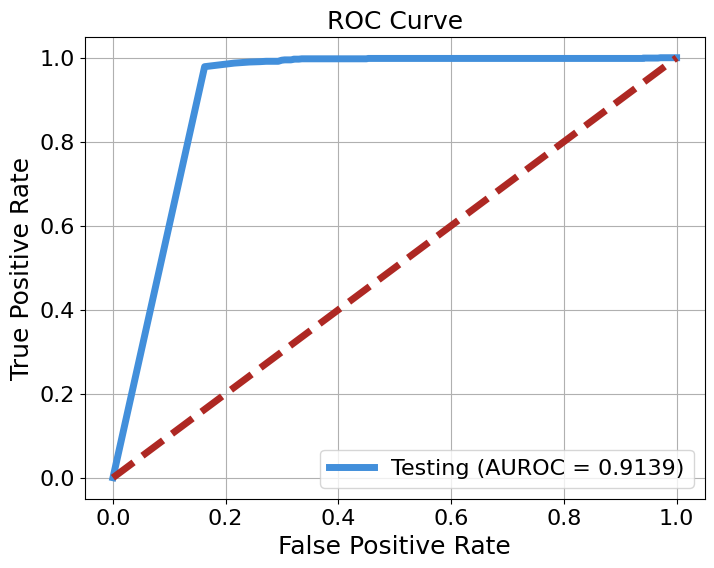

In [13]:
import numpy as np
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
def plot_roc_curve(labels, scores):#ROC
    fpr, tpr, _ = metrics.roc_curve(labels, scores)
    roc_auc = metrics.auc(fpr, tpr)#ROC曲线的值，AUC
     
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr,  color='#428fdb', lw=5, label='Testing (AUROC = %0.4f)' % roc_auc)
    plt.title('ROC Curve',fontsize=18)
    plt.plot([0, 1], [0, 1], color='#ae2823', lw=5, linestyle='--')
    # plt.xlim([0.0, 1.0])
    # plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate',fontsize=18)
    plt.ylabel('True Positive Rate',fontsize=18)
    legend_font = {'size': 16}
    plt.legend(loc='lower right',prop=legend_font)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)
    plt.savefig("assets/T5_circaEmbed_FAN/plot/ROC.svg", format='svg', bbox_inches='tight')
    plt.show()
plot_roc_curve(np.array(labels),np.array(scores))

FileNotFoundError: [Errno 2] No such file or directory: 'assets/T5_circaEmbed_FAN/plot/PR.svg'

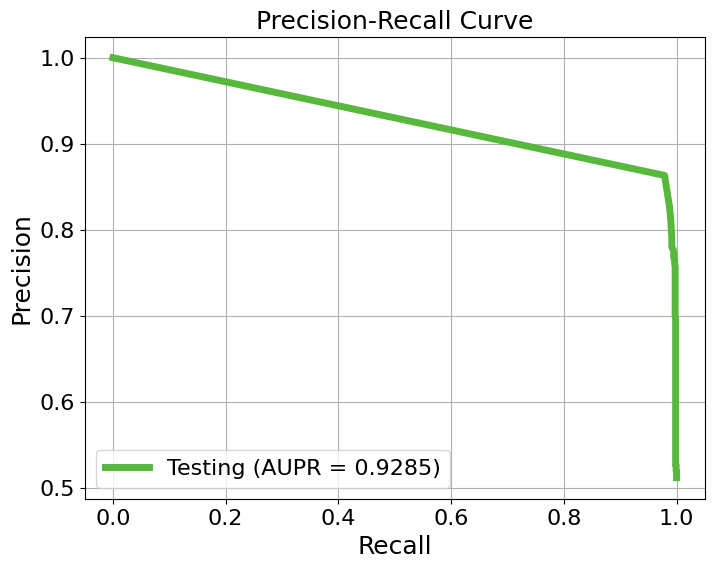

In [14]:
import numpy
import numpy as np
def plot_2class_pr_curve(labels:numpy.ndarray, scores:numpy.ndarray):
    precision1, recall1, _ = metrics.precision_recall_curve(labels, scores)

    aupr1=metrics.auc(recall1, precision1)

    # aupr1 = metrics.average_precision_score(labels_class1, scores[:,1])
    # aupr2 = metrics.average_precision_score(labels_class2, scores[:,0])
    plt.figure(figsize=(8, 6))
    plt.plot(recall1, precision1, color='#57b83b', lw=5, label=f'Testing (AUPR = {aupr1:.4f})')
    plt.title('Precision-Recall Curve',fontsize=18)
    plt.xlabel('Recall',fontsize=18)
    plt.ylabel('Precision',fontsize=18)
    legend_font = {'size': 16}
    plt.legend(loc='lower left',prop=legend_font)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)
    plt.savefig("assets/T5_circaEmbed_FAN/plot/PR.svg", format='svg', bbox_inches='tight')
    # plt.grid(True)
    plt.show()
plot_2class_pr_curve(np.array(labels), np.array(scores))

In [15]:
report=Metric.get_classification_report(labels,predict)
print(report)

              precision    recall  f1-score   support

           0     0.9963    0.4817    0.6494      1119
           1     0.6688    0.9983    0.8010      1173

    accuracy                         0.7461      2292
   macro avg     0.8325    0.7400    0.7252      2292
weighted avg     0.8287    0.7461    0.7270      2292



In [16]:
# from datetime import datetime
# from utils.metrics import Metric
# best_val_accuracy,best_test_accuracy = 0.0,0.0
# currentEpoch=0
# current_time = datetime.now()
# c_time = current_time.strftime("%y_%m_%d_%H_%M")
# trainAddr=os.path.join("assets/RealDST-T1")

# for epoch in range(config.num_epochs):
#       currentEpoch = epoch + 1

#       trainSave={'loss':[],'accuracy':[],'targets':[],'preds':[],'scores':[]}
#       # for key in data:
#       key="dup0"
#       scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-4,total_steps=config.num_epochs*len(data[key]))
#       train_result=train_epoch(model,device,data[key],optimizer,criterion,scheduler)
#       # test_result=test_epoch(model,train_dataloader,device,criterion)
#       for kk in trainSave:
#             trainSave[kk].extend(train_result[kk])

#       print(f"Epoch [{currentEpoch}/{config.num_epochs},{key}]")
#       print(f"Train Loss: {train_result['loss'][0]:.4f}, Train Accuracy: {train_result['accuracy'][0]:.4f}")
            
      
#       Metric.save_metrics(trainSave,trainAddr,"current_res.json",currentEpoch,c_time,mode='w')

#       acc=np.array(trainSave["accuracy"]).mean()
#       if acc > best_val_accuracy:
#             best_val_accuracy =acc
#             Metric.save_metrics(trainSave,trainAddr,"best_res.json",currentEpoch,c_time,mode='w')
#             # 保存当前最好的模型
#             save_checkpoint(model,savePath="best_model.pth")
#             print(f"Saving Test checkpoint with accuracy: {acc:.4f} at epoch {currentEpoch}")